In [464]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
import seaborn as sns

In [528]:
debug=False

def my_print(str):
    if (debug):
        print(str)
        
# https://stackoverflow.com/a/40347279
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

def get_clean_data(folder, name, batch_qty):
    input_df = pd.read_csv(f'{folder}/{name}.csv', header=None, nrows=batch_qty*5)

    before_len = len(input_df)
    
    my_print("Cleaning " + name + ".csv (" + str(before_len) + " rows)")
    
    allowed_http_codes = [200, 302]
    
    input_df = input_df[(input_df[1].isin(allowed_http_codes)) & (input_df[2].isin(allowed_http_codes))]

    my_print(str(before_len - len(input_df)) + " rows with unexpected http codes")

    before_len = len(input_df)
    input_df = input_df[(np.abs(stats.zscore(input_df[0])) < 3)]
    
    my_print(str(before_len - len(input_df)) + " rows with outliers")
    
    return input_df[0]

# NOTE no outlier removal etc - here we are trying to see how effective the most naive implemetantion would be. 
# I.e. how likely it is that an attack is accurate given a small sample of salvos (i.e. 5 pairs as the entire attack).  
def overall_result(folder, name, batch_qty):
    input_df = pd.read_csv(f'{folder}/{name}.csv', header=None, nrows=batch_qty)
    total_qty = len(input_df)
    suspect_email_exists_qty = len(input_df[input_df[0] == 0])

    pct = (suspect_email_exists_qty / total_qty) * 100
    
    my_print(f'{suspect_email_exists_qty} of {total_qty} ({pct}%) results indicate a user exists with the given email')

# Locations: local, remote
# Types: attack, control
def analyse_result_folder(folder, locations, types, batch_qty=10000):
    df = pd.DataFrame()
    
    for type in types:
        for location in locations:
            my_print(f'\n{folder} {location} {type}') 
            
            name = f'{location}_{type}_detail'
            
            df[name] = get_clean_data(folder, name, batch_qty)

            name = f'{location}_{type}_winners'
            
            overall_result(folder, name, batch_qty)

    xlim=5e8
    
    # df.plot(
    #     kind='kde', 
    #     # bw_method=0.1,
    #     figsize=(15,5), 
    #     color=['red', 'olivedrab', 'goldenrod', 'mediumseagreen'],
    #     xlim=(-xlim, xlim)
    # )

    folder_segments = folder.split('/')
    seq_or_con = folder_segments[1]
    rand_or_not = folder_segments[2]
    latency = int(folder_segments[3][:3])/10
    jitter = int(folder_segments[3][3:])/10

    title = f'{seq_or_con} {rand_or_not}, latency: {latency}ms, jitter: {jitter}ms'.capitalize()
    
    ax = df.plot.kde(
        # bw_method=0.1,
        title=title,
        figsize=(15,5), 
        color=['red', 'olivedrab', 'goldenrod', 'mediumseagreen'],
        xlim=(-xlim, xlim)
    )
    # ax.legend(['First List', 'Second List'], loc='upper left')
    ax.set_xlabel('Pair-wise response time diff (nanoseconds)' , fontsize=12)

In [486]:
# While the above kde chart is useful for improving our mental model of how the attack works, all a real attacker really needs to know is 
# whether responses typically arrived at about the same time. 
# Our analysis suggests that only one batch of 5 pairs is required, even in the remote (over the internet) context

# Suprised that the spread is wider for local vs. remote. Perhaps something to do with virtualisation, or some other detail of the specific
# deployment of the contrived target app. What's cool about this attack though, is that we don't care about that kind of detail at all! 
# All we care about is "did the response pairs arrive back at about the same time?". 

# As you would expect, remote probes take longer in general, vs. local


# What is most interesting in these results is how obvious the difference between control and attack is. 
# This suggests that any single indicator in the attack data of the target user existing is probably good enough
# Itis very likely that the first salvo will be enough, and if not, only 2 or 3 should be required nuder most circumstances. 

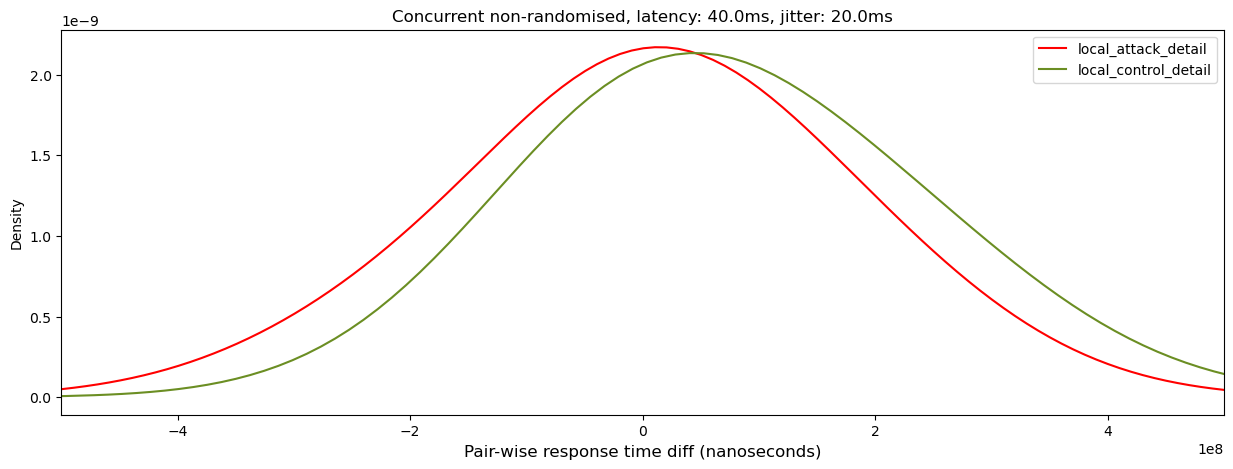

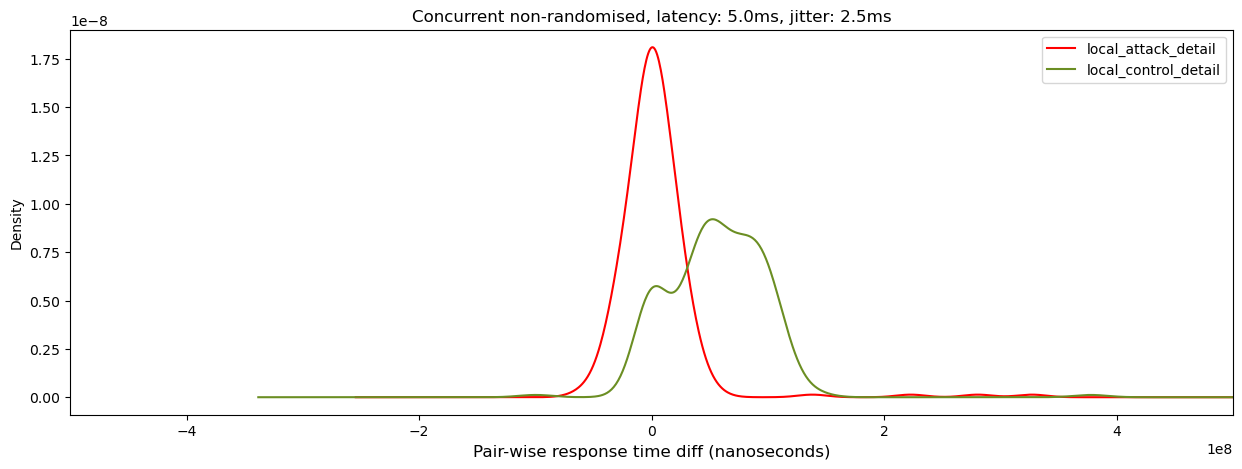

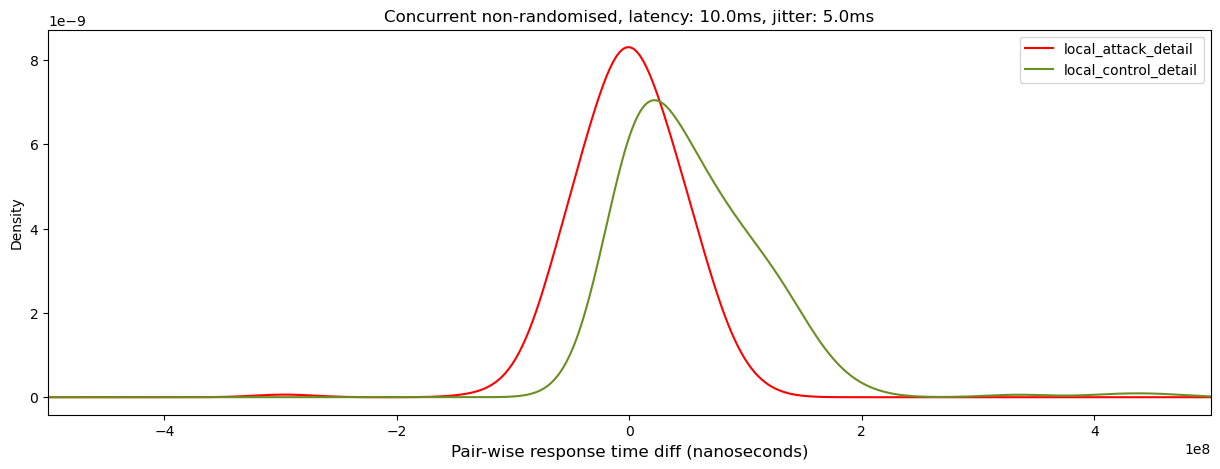

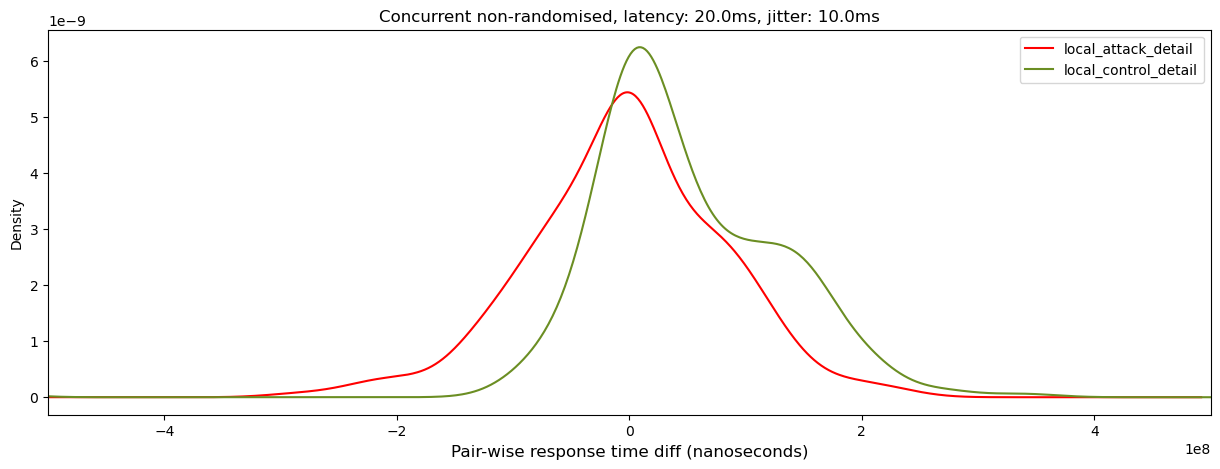

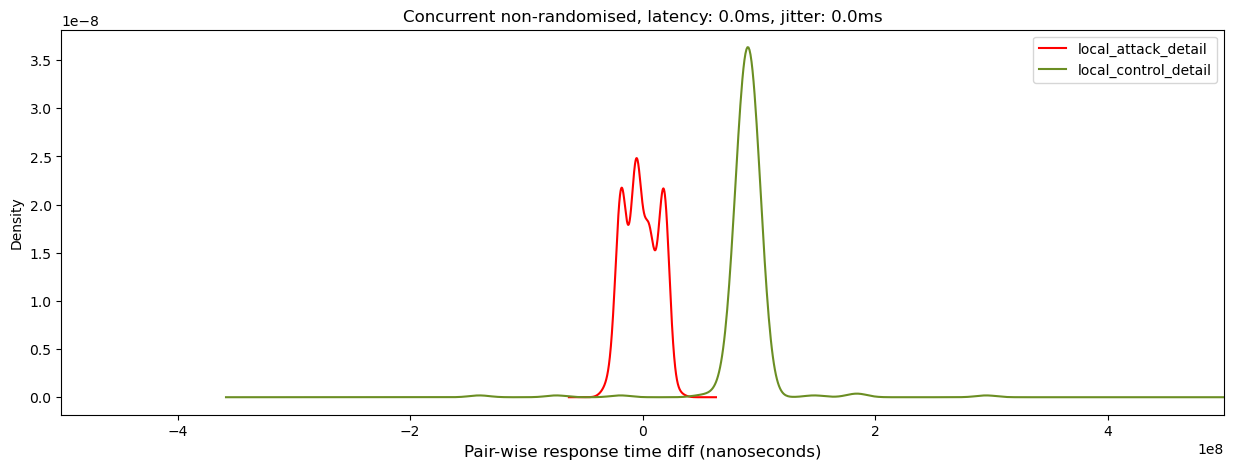

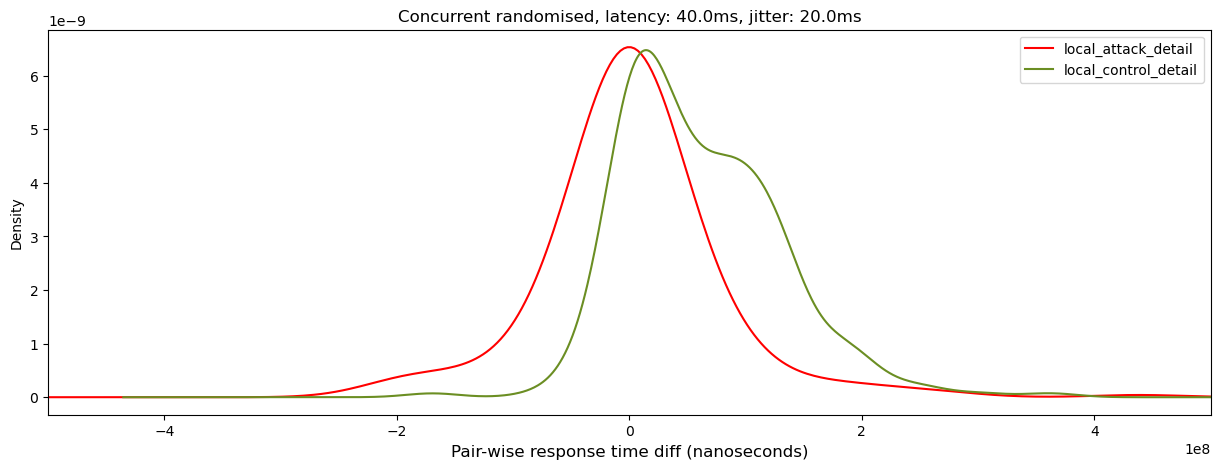

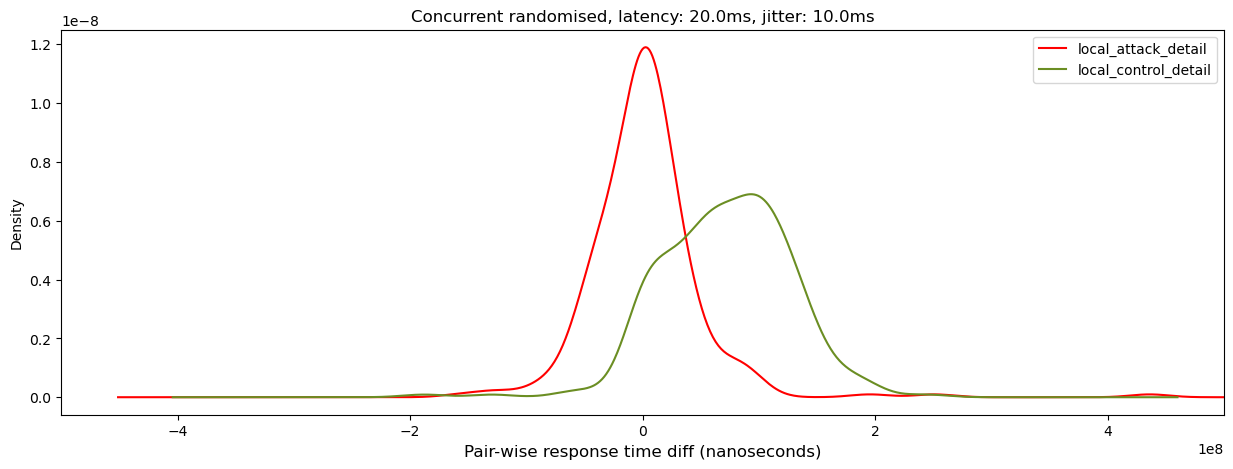

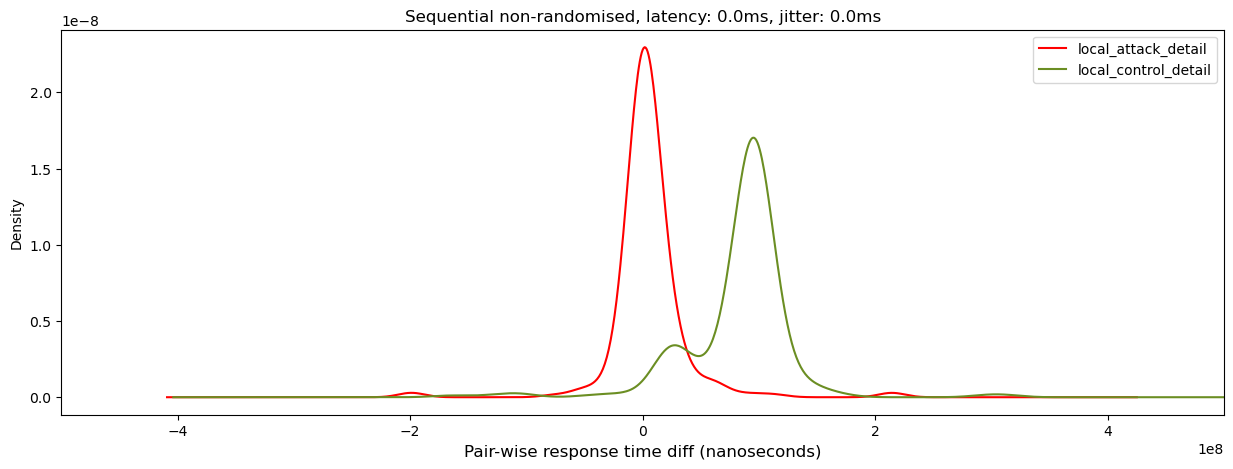

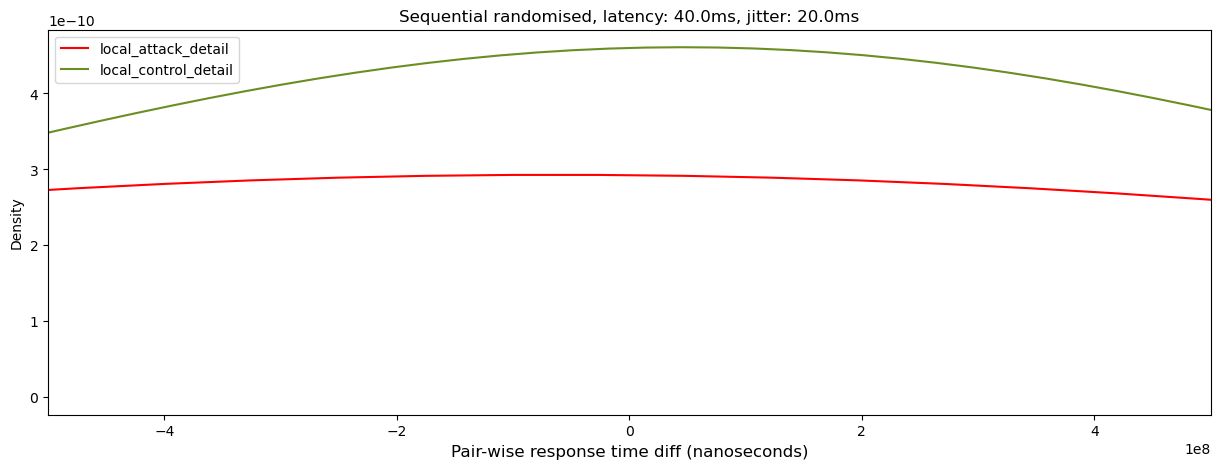

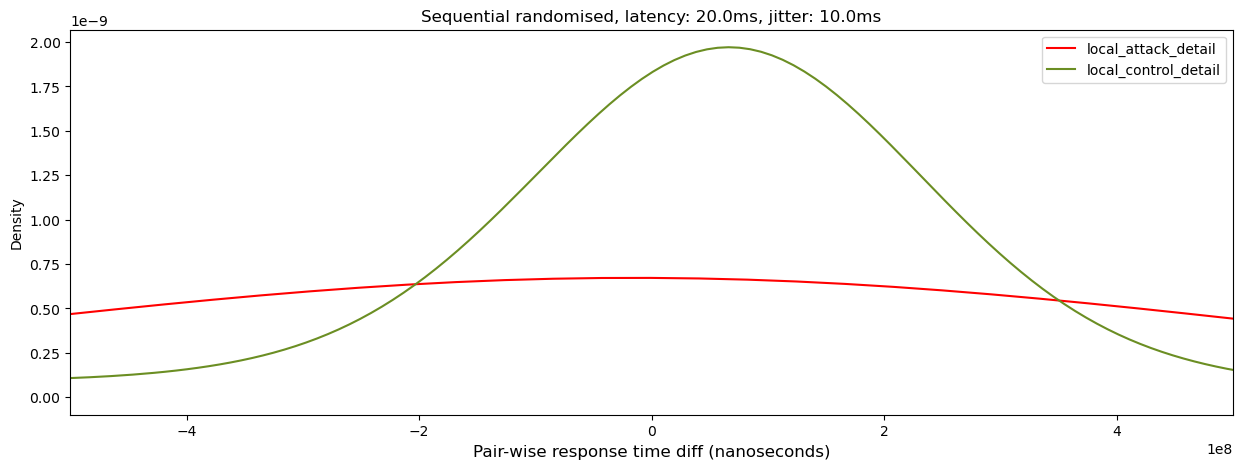

In [529]:
for path in fast_scandir('completed_results'):
    if path.count('/') == 3:
         analyse_result_folder(path, ["local"], ["attack", "control"], 50)

In [457]:
analyse_result_folder("results_wifi_20ms_10ms", ["local"], ["attack", "control"])


results_wifi_20ms_10ms local attack


FileNotFoundError: [Errno 2] No such file or directory: 'results_wifi_20ms_10ms/local_attack_detail.csv'

In [ ]:
analyse_result_folder("results_wifi_10ms_5ms", ["local"], ["attack", "control"])

In [ ]:
analyse_result_folder("results_wifi_5ms_2.5ms", ["local"], ["attack", "control"])


In [ ]:
analyse_result_folder("results_wifi_0ms_0ms", ["local"], ["attack", "control"])

In [ ]:
analyse_result_folder("results_wifi_20ms_10ms_randomised", ["local"], ["attack", "control"])

In [ ]:
analyse_result_folder("results_wifi_40ms_20ms_randomised", ["local"], ["attack", "control"])

In [ ]:
analyse_result_folder("results_sequential_wifi_0ms_0ms", ["local"], ["attack", "control"])

In [ ]:
analyse_result_folder("results_sequential_wifi_40ms_20ms_randomised", ["local"], ["attack", "control"])

In [ ]:
analyse_result_folder("results_sequential_wifi_20ms_10ms_randomised", ["local"], ["attack", "control"])

In [ ]:
analyse_result_folder("results_wifi_0ms_0ms", ["local"], ["attack", "control"], 90)

In [ ]:
analyse_result_folder("results_wifi_0ms_0ms", ["remote"], ["attack", "control"], 90)